In [2]:
# 코랩환경에서만 사용
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# pandas, numpy import
# tqdm, random, os 는 필요시 import
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

DATA_PATH = "/content/drive/MyDrive/Guide_Project/"
SEED = 42


In [4]:
reset_seeds(SEED)

In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.7 MB/s eta 0:00:00


In [6]:
# 모델 관련 library import
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
import joblib
warnings.filterwarnings('ignore')


In [7]:
# train, test 불러오기
train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')

In [9]:
# building_info 불러오기
building_info = pd.read_csv(f"{DATA_PATH}building_info.csv")

In [11]:
# train data 일시 컬럼 수정
date = pd.to_datetime(train_df['일시'])
train_df['hour'] = date.dt.hour
train_df['day'] = date.dt.weekday
train_df['month'] = date.dt.month
train_df['week'] = date.dt.weekofyear

In [12]:
building_info

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


In [13]:
train_df


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),hour,day,month,week
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,0,2,6,22
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,1,2,6,22
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,2,2,6,22
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,3,2,6,22
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,4,2,6,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04,19,2,8,34
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96,20,2,8,34
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12,21,2,8,34
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08,22,2,8,34


In [14]:
cols = ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']
for col in cols :
    building_info[col] = building_info[col].apply(lambda x : 0 if x =='-' else float(x))
building_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    float64
 5   ESS저장용량(kWh)  100 non-null    float64
 6   PCS용량(kW)     100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


In [15]:

# train 데이터와 test 데이터간 컬럼이 다름
# 불필요한 컬럼 제거
train_ft = train_df.drop(columns=['num_date_time', '일시','일조(hr)', '일사(MJ/m2)'])
test_ft = test_df.drop(columns=['num_date_time', '일시'])

# train 강수량 컬럼 채우기
train_ft['강수량(mm)']= train_ft['강수량(mm)'].fillna(0)

In [16]:
train_df[train_df['풍속(m/s)'].isnull()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),hour,day,month,week
16643,9_20220614 11,9,20220614 11,17.6,NaN,NaN,NaN,NaN,NaN,2330.40,11,1,6,24
30161,15_20220806 17,15,20220806 17,35.6,NaN,NaN,NaN,NaN,NaN,1815.57,17,5,8,31
32127,16_20220803 15,16,20220803 15,30.4,NaN,NaN,77.0,0.5,2.06,5062.08,15,2,8,31
51640,26_20220627 16,26,20220627 16,27.2,3.1,NaN,93.0,0.0,0.27,5330.40,16,0,6,26
51921,26_20220709 09,26,20220709 09,26.3,NaN,NaN,84.0,0.0,0.81,2908.80,9,5,7,27
84418,42_20220703 10,42,20220703 10,29.8,NaN,NaN,66.0,1.0,2.61,3038.76,10,6,7,26
100738,50_20220703 10,50,20220703 10,29.8,NaN,NaN,66.0,1.0,2.61,3044.70,10,6,7,26
105639,52_20220806 15,52,20220806 15,33.4,NaN,NaN,72.0,0.0,NaN,2260.20,15,5,8,31
105640,52_20220806 16,52,20220806 16,33.5,NaN,NaN,73.0,0.0,NaN,2274.30,16,5,8,31
176477,87_20220714 05,87,20220714 05,21.9,NaN,NaN,NaN,NaN,NaN,519.66,5,3,7,28


In [17]:
# 풍속 결측치 채우기
# 같은 건물, 같은 월, 같은 시간 기준으로 평균내서 결측치 채우기
for i in train_ft[train_ft['풍속(m/s)'].isnull()].index:
    # display(train_ft.iloc[i])
    month = train_ft.iloc[i]['month']
    hour = train_ft.iloc[i]['hour']
    num = train_ft.iloc[i]['건물번호']
    data_mean = train_ft[(train_ft['건물번호']==num)&(train_ft['month']==month) & (train_ft['hour'] ==hour)]['풍속(m/s)'].describe()['mean']
    train_ft.loc[i,'풍속(m/s)'] = data_mean


# 결측치 없어진 것 확인
train_ft['풍속(m/s)'].isnull().sum()

0

In [18]:

# 습도도 같은 방법으로 진행
for i in train_ft[train_ft['습도(%)'].isnull()].index:
    # display(train_ft.iloc[i])
    month = train_ft.iloc[i]['month']
    hour = train_ft.iloc[i]['hour']
    num = train_ft.iloc[i]['건물번호']
    data_mean = train_ft[(train_ft['건물번호']==num)&(train_ft['month']==month) & (train_ft['hour'] ==hour)]['습도(%)'].describe()['mean']
    train_ft.loc[i,'습도(%)'] = data_mean

In [19]:
# train 과 test에 건물번호로 테이블 합쳐주기
train_ft = train_ft.merge(building_info,how='left',on='건물번호')
test_ft = test_ft.merge(building_info,how='left',on='건물번호')

In [20]:
# mapping 할 dictionary 생성
conv_dict = dict(zip(list(train_ft['건물유형'].unique()), [0,1,2,3,4,5,6,7,8,9,10,11]))
conv_dict


{'건물기타': 0,
 '공공': 1,
 '대학교': 2,
 '데이터센터': 3,
 '백화점및아울렛': 4,
 '병원': 5,
 '상용': 6,
 '아파트': 7,
 '연구소': 8,
 '지식산업센터': 9,
 '할인마트': 10,
 '호텔및리조트': 11}

In [21]:
# mapping
train_ft['건물유형'] = train_ft['건물유형'].map(conv_dict)
test_ft['건물유형'] = test_ft['건물유형'].map(conv_dict)


In [22]:
target = train_df['전력소비량(kWh)']
target



0         1085.28
1         1047.36
2          974.88
3          953.76
4          986.40
           ...   
203995     881.04
203996     798.96
203997     825.12
203998     640.08
203999     540.24
Name: 전력소비량(kWh), Length: 204000, dtype: float64

In [23]:
train_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
test_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

In [24]:
train_ft['sin_time'] = np.sin(2*np.pi*train_ft.hour/24)
train_ft['cos_time'] = np.cos(2*np.pi*train_ft.hour/24)

test_ft['cos_time'] = np.cos(2*np.pi*train_ft.hour/24)
test_ft['sin_time'] = np.sin(2*np.pi*train_ft.hour/24)

In [25]:
train_ft['THI'] = 9/5*train_ft['기온(C)'] - 0.55*(1-train_ft['습도(%)']/100)*(9/5*train_ft['습도(%)']-26)+32
#test_ft['THI'] = 9/5*test_ft['기온(C)'] - 0.55*(1-test_ft['습도(%)']/100)*(9/5*test_ft['습도(%)']-26)+32


# 불쾌지수 구간별 레이블 달아주기 -> 레이블 없이 값으로 가
#train_ft['THI'] = pd.cut(train_ft['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
#train_ft['THI'] = train_ft['THI'].astype(int)
#test_ft['THI'] = pd.cut(test_ft['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
#test_ft['THI'] = test_ft['THI'].astype(int)

In [26]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)


cdhs = np.array([])
for num in range(1,101,1):
    temp = train_ft[train_ft['건물번호'] == num]
    cdh = CDH(temp['기온(C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
train_ft['CDH'] = cdhs


cdhs = np.array([])
for num in range(1,101,1):
    temp = test_ft[test_ft['건물번호'] == num]
    cdh = CDH(temp['기온(C)'].values)
    cdhs = np.concatenate([cdhs, cdh])
test_ft['CDH'] = cdhs

In [28]:
power_mean = pd.pivot_table(train_ft, values = '전력소비량(kWh)', index = ['건물번호', 'hour', 'day','month'], aggfunc = np.mean).reset_index()

power_mean = power_mean.drop_duplicates(subset=['건물번호', 'hour', 'day'], keep='first')

train_ft = train_ft.merge(power_mean[['건물번호', 'hour', 'day', '전력소비량(kWh)']],
                          on=['건물번호', 'hour', 'day'],
                          how='left',
                          suffixes=('', '_mean'))
train_ft.rename(columns={'전력소비량(kWh)_mean': 'day_hour_mean'}, inplace=True)

#test_ft = train_ft.merge(power_mean[['건물번호', 'hour', 'day', '전력소비량(kWh)']],
                        #on=['건물번호', 'hour', 'day'],
                        #how='left',
                        #suffixes=('', '_mean'))
#test_ft.rename(columns={'전력소비량(kWh)': 'day_hour_mean'}, inplace=True)


In [29]:
power_mean = pd.pivot_table(train_ft, values = '전력소비량(kWh)', index = ['건물번호', 'hour', 'day','month'], aggfunc = np.mean).reset_index()

power_mean = power_mean.drop_duplicates(subset=['건물번호', 'hour', 'month'], keep='first')

train_ft = train_ft.merge(power_mean[['건물번호', 'hour', 'month', '전력소비량(kWh)']],
                          on=['건물번호', 'hour', 'month'],
                          how='left',
                          suffixes=('', '_mean'))
train_ft.rename(columns={'전력소비량(kWh)_mean': 'month_hour_mean'}, inplace=True)

#test_ft = test_ft.merge(power_mean[['건물번호', 'hour', 'month', '전력소비량(kWh)']],
#                        on=['건물번호', 'hour', 'month'],
#                        how='left',
#                        suffixes=('', '_mean'))
#test_ft.rename(columns={'전력소비량(kWh)': 'month_hour_mean'}, inplace=True)

In [30]:
power_mean = pd.pivot_table(train_ft, values = '전력소비량(kWh)', index = ['건물번호', 'hour'], aggfunc = np.mean).reset_index()
train_ft = train_ft.merge(power_mean[['건물번호', 'hour', '전력소비량(kWh)']],
                          on=['건물번호', 'hour'],
                          how='left',
                          suffixes=('', '_mean'))
train_ft.rename(columns={'전력소비량(kWh)_mean': 'hour_mean'}, inplace=True)

In [31]:
power_std = pd.pivot_table(train_ft, values = '전력소비량(kWh)', index = ['건물번호', 'hour'], aggfunc = np.std).reset_index()
train_ft = train_ft.merge(power_std[['건물번호', 'hour', '전력소비량(kWh)']],
                          on=['건물번호', 'hour'],
                          how='left',
                          suffixes=('', '_std'))
train_ft.rename(columns={'전력소비량(kWh)_std': 'hour_std'}, inplace=True)


In [32]:
power_std = pd.pivot_table(train_ft, values = '전력소비량(kWh)', index = ['건물번호', 'hour', 'day'], aggfunc = np.std).reset_index()
train_ft = train_ft.merge(power_std[['건물번호', 'hour', 'day', '전력소비량(kWh)']],
                          on=['건물번호', 'hour', 'day'],
                          how='left',
                          suffixes=('', '_std'))
train_ft.rename(columns={'전력소비량(kWh)_std': 'day_hour_std'}, inplace=True)


In [33]:
power_median = pd.pivot_table(train_ft, values = '전력소비량(kWh)', index = ['건물번호', 'hour', 'day'], aggfunc = np.median).reset_index()
train_ft = train_ft.merge(power_median[['건물번호', 'hour', 'day', '전력소비량(kWh)']],
                          on=['건물번호', 'hour', 'day'],
                          how='left',
                          suffixes=('', '_median'))
train_ft.rename(columns={'전력소비량(kWh)_median': 'day_hour_median'}, inplace=True)

In [34]:
train_ft = train_ft.drop(columns=['holiday', '건물유형', '강수량(mm)', '풍속(m/s)','전력소비량(kWh)'])

In [35]:
cols = ['건물번호', '기온(C)', '습도(%)', 'hour', 'day', 'month', 'week', '연면적(m2)',
       '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', 'sin_time',
       'cos_time', 'THI', 'CDH', 'day_hour_mean', 'month_hour_mean','hour_mean', 'hour_std','day_hour_std',
       'day_hour_median']

In [36]:
train_ft= train_ft[cols]
#test_ft = test_ft[cols]

In [37]:
train_ft['전력소비량(kWh)'] = train_df['전력소비량(kWh)']

In [38]:
train_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
#test_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)


weekday_mean = train_ft[train_ft.holiday==0].pivot_table(values='전력소비량(kWh)', index=train_ft.건물번호, columns='hour', aggfunc='first') # 평일 시간당 소비전력


weekend_mean = train_ft[train_ft.holiday==1].pivot_table(values='전력소비량(kWh)', index=train_ft.건물번호, columns='hour', aggfunc='first')


tmp = pd.merge(weekday_mean,weekend_mean,how='left',on = '건물번호')
tmp

hour,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y
건물번호,,,,,,,,,,,,,,,,,,,,,
1,1085.28,1047.36,974.88,953.76,986.40,1087.20,1314.72,1684.80,1976.16,2289.12,...,3210.24,3153.60,3035.52,2726.40,2315.04,2229.60,2069.76,1733.76,1414.08,1191.84
2,1170.36,1146.96,1115.28,1107.00,1069.92,1075.32,1116.36,1254.24,887.40,1035.00,...,2245.68,2316.60,2528.28,2201.04,2028.60,1636.56,1380.96,1109.52,811.44,1268.64
3,926.28,884.52,882.36,867.24,880.92,808.56,786.24,809.64,818.64,882.36,...,1596.96,1791.72,1875.60,1746.00,1794.24,2265.48,2087.28,1052.64,972.72,912.60
4,740.16,671.04,619.20,626.40,626.22,630.36,752.04,829.44,957.60,1093.14,...,1237.50,1226.52,1172.70,1064.88,959.04,875.88,816.12,755.10,708.48,656.28
5,1304.64,1308.24,1302.48,1295.28,1316.88,1398.96,1492.56,1535.04,1548.72,1560.96,...,5785.92,5768.64,5553.36,5284.80,2644.56,1645.92,1538.64,1463.04,1404.00,1416.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1576.68,1558.68,1413.36,1483.92,1438.56,1503.84,1738.80,2073.36,2263.80,2621.04,...,3095.16,3043.80,3042.36,2958.84,2883.48,2780.04,2729.28,2525.88,2098.44,1848.72
97,774.36,553.86,558.90,559.44,559.62,582.48,640.26,903.78,855.18,907.56,...,1486.44,1469.88,1471.50,1340.46,1215.90,1180.98,1275.30,1128.42,975.96,895.14
98,533.52,516.78,509.40,479.70,541.98,712.08,947.88,1004.58,1069.02,1133.64,...,1298.16,1296.72,1273.32,1298.70,1238.22,1139.58,1093.68,979.20,783.00,654.30


In [39]:
kmeans= KMeans(n_clusters=5,random_state=SEED,n_init='auto')
kmeans.fit(tmp)

KMeans(n_clusters=5, n_init='auto', random_state=42)

In [40]:
cluster_ = kmeans.predict(tmp)


tmp['cluster'] = cluster_


train_ft = train_ft.merge(tmp.cluster,how='left',on='건물번호')
#test_ft = test_ft.merge(tmp.cluster,how='left',on='건물번호')


train_ft = train_ft.drop(columns=['holiday'])
#test_ft = test_ft.drop(columns=['holiday'])


In [42]:
power_mean = pd.pivot_table(train_ft, values = '전력소비량(kWh)', index = ['cluster', 'hour', 'day','month'], aggfunc = np.mean).reset_index()

power_mean = power_mean.drop_duplicates(subset=['cluster', 'hour', 'day'], keep='first')

train_ft = train_ft.merge(power_mean[['cluster', 'hour', 'day', '전력소비량(kWh)']],
                          on=['cluster', 'hour', 'day'],
                          how='left',
                          suffixes=('', '_mean'))
train_ft.rename(columns={'전력소비량(kWh)_mean': 'cluster_day_hour_mean'}, inplace=True)

#test_ft = test_ft.merge(power_mean[['cluster', 'hour', 'day', '전력소비량(kWh)']],
                        #on=['cluster', 'hour', 'day'],
                        #how='left',
                        #suffixes=('', '_mean'))
#test_ft.rename(columns={'전력소비량(kWh)': 'cluster_day_hour_mean'}, inplace=True)


display(train_ft)
###display(test_ft)


,건물번호,기온(C),습도(%),hour,day,month,week,연면적(m2),냉방면적(m2),태양광용량(kW),...,CDH,day_hour_mean,month_hour_mean,hour_mean,hour_std,day_hour_std,day_hour_median,전력소비량(kWh),cluster,cluster_day_hour_mean
0,1,18.6,42.0,0,2,6,22,110634.00,39570.00,0.0,...,-7.4,1174.656,1189.44,1706.318118,446.882767,517.982222,2094.72,1085.28,0,2005.185000
1,1,18.0,45.0,1,2,6,22,110634.00,39570.00,0.0,...,-15.4,1101.600,1131.12,1622.620235,439.662704,500.769931,2015.52,1047.36,0,1952.292000
2,1,17.7,45.0,2,2,6,22,110634.00,39570.00,0.0,...,-23.7,1025.760,1063.56,1506.971294,412.071906,465.227458,1848.00,974.88,0,1918.248500
3,1,16.7,48.0,3,2,6,22,110634.00,39570.00,0.0,...,-33.0,1015.584,1042.68,1437.365647,391.205981,436.601091,1764.00,953.76,0,1894.579500
4,1,18.4,43.0,4,2,6,22,110634.00,39570.00,0.0,...,-40.6,1041.792,1075.44,1447.321412,381.099697,405.518091,1619.52,986.40,0,1901.786500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,86.0,19,2,8,34,57497.84,40035.23,0.0,...,-19.6,832.752,1168.20,1010.462118,161.399578,163.825489,1017.12,881.04,4,1424.581127
203996,100,22.4,86.0,20,2,8,34,57497.84,40035.23,0.0,...,-20.2,773.040,1026.00,928.125176,137.566008,153.076049,874.32,798.96,4,1353.478945
203997,100,21.3,92.0,21,2,8,34,57497.84,40035.23,0.0,...,-22.3,686.784,934.68,830.032941,128.300189,143.415686,781.20,825.12,4,1228.707309
203998,100,21.0,94.0,22,2,8,34,57497.84,40035.23,0.0,...,-25.1,584.736,815.52,723.100235,112.464079,105.147190,657.12,640.08,4,1073.485988


In [43]:

# 7일 x 24시간 = 168시간
window_size = 96

train_ft['기온_4일_이동평균'] = train_ft.groupby('건물번호')['기온(C)'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

train_ft['습도_4일_이동평균'] = train_ft.groupby('건물번호')['습도(%)'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

window_size = 168

train_ft['기온_7일_이동평균'] = train_ft.groupby('건물번호')['기온(C)'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

train_ft['습도_7일_이동평균'] = train_ft.groupby('건물번호')['습도(%)'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())


train_ft.head()


,건물번호,기온(C),습도(%),hour,day,month,week,연면적(m2),냉방면적(m2),태양광용량(kW),...,hour_std,day_hour_std,day_hour_median,전력소비량(kWh),cluster,cluster_day_hour_mean,기온_4일_이동평균,습도_4일_이동평균,기온_7일_이동평균,습도_7일_이동평균
0,1,18.6,42.0,0,2,6,22,110634.0,39570.0,0.0,...,446.882767,517.982222,2094.72,1085.28,0,2005.1850,18.60,42.0,18.60,42.0
1,1,18.0,45.0,1,2,6,22,110634.0,39570.0,0.0,...,439.662704,500.769931,2015.52,1047.36,0,1952.2920,18.30,43.5,18.30,43.5
2,1,17.7,45.0,2,2,6,22,110634.0,39570.0,0.0,...,412.071906,465.227458,1848.00,974.88,0,1918.2485,18.10,44.0,18.10,44.0
3,1,16.7,48.0,3,2,6,22,110634.0,39570.0,0.0,...,391.205981,436.601091,1764.00,953.76,0,1894.5795,17.75,45.0,17.75,45.0
4,1,18.4,43.0,4,2,6,22,110634.0,39570.0,0.0,...,381.099697,405.518091,1619.52,986.40,0,1901.7865,17.88,44.6,17.88,44.6


일단 THI, day_hour_mean(전력사용량평균), 습도, 기온 사용하자.
전력 사용량에 대해 각 변수들을 사용해 상관분석부터.

In [44]:
train_ft.drop_duplicates()

,건물번호,기온(C),습도(%),hour,day,month,week,연면적(m2),냉방면적(m2),태양광용량(kW),...,hour_std,day_hour_std,day_hour_median,전력소비량(kWh),cluster,cluster_day_hour_mean,기온_4일_이동평균,습도_4일_이동평균,기온_7일_이동평균,습도_7일_이동평균
0,1,18.6,42.0,0,2,6,22,110634.00,39570.00,0.0,...,446.882767,517.982222,2094.72,1085.28,0,2005.185000,18.600000,42.000000,18.600000,42.000000
1,1,18.0,45.0,1,2,6,22,110634.00,39570.00,0.0,...,439.662704,500.769931,2015.52,1047.36,0,1952.292000,18.300000,43.500000,18.300000,43.500000
2,1,17.7,45.0,2,2,6,22,110634.00,39570.00,0.0,...,412.071906,465.227458,1848.00,974.88,0,1918.248500,18.100000,44.000000,18.100000,44.000000
3,1,16.7,48.0,3,2,6,22,110634.00,39570.00,0.0,...,391.205981,436.601091,1764.00,953.76,0,1894.579500,17.750000,45.000000,17.750000,45.000000
4,1,18.4,43.0,4,2,6,22,110634.00,39570.00,0.0,...,381.099697,405.518091,1619.52,986.40,0,1901.786500,17.880000,44.600000,17.880000,44.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,86.0,19,2,8,34,57497.84,40035.23,0.0,...,161.399578,163.825489,1017.12,881.04,4,1424.581127,25.161458,87.552083,25.341667,86.809524
203996,100,22.4,86.0,20,2,8,34,57497.84,40035.23,0.0,...,137.566008,153.076049,874.32,798.96,4,1353.478945,25.127083,87.531250,25.327976,86.875000
203997,100,21.3,92.0,21,2,8,34,57497.84,40035.23,0.0,...,128.300189,143.415686,781.20,825.12,4,1228.707309,25.094792,87.489583,25.321429,86.892857
203998,100,21.0,94.0,22,2,8,34,57497.84,40035.23,0.0,...,112.464079,105.147190,657.12,640.08,4,1073.485988,25.063542,87.458333,25.311905,86.928571


In [45]:
train_ft.head()

,건물번호,기온(C),습도(%),hour,day,month,week,연면적(m2),냉방면적(m2),태양광용량(kW),...,hour_std,day_hour_std,day_hour_median,전력소비량(kWh),cluster,cluster_day_hour_mean,기온_4일_이동평균,습도_4일_이동평균,기온_7일_이동평균,습도_7일_이동평균
0,1,18.6,42.0,0,2,6,22,110634.0,39570.0,0.0,...,446.882767,517.982222,2094.72,1085.28,0,2005.1850,18.60,42.0,18.60,42.0
1,1,18.0,45.0,1,2,6,22,110634.0,39570.0,0.0,...,439.662704,500.769931,2015.52,1047.36,0,1952.2920,18.30,43.5,18.30,43.5
2,1,17.7,45.0,2,2,6,22,110634.0,39570.0,0.0,...,412.071906,465.227458,1848.00,974.88,0,1918.2485,18.10,44.0,18.10,44.0
3,1,16.7,48.0,3,2,6,22,110634.0,39570.0,0.0,...,391.205981,436.601091,1764.00,953.76,0,1894.5795,17.75,45.0,17.75,45.0
4,1,18.4,43.0,4,2,6,22,110634.0,39570.0,0.0,...,381.099697,405.518091,1619.52,986.40,0,1901.7865,17.88,44.6,17.88,44.6


In [46]:
x = train_ft['THI'].values
y = train_ft['cluster_day_hour_mean'].values

import matplotlib.pyplot as plt

In [47]:
x

array([49.6576, 47.7625, 47.2225, ..., 64.1976, 65.0744, 65.2725])

In [48]:
y

array([2005.185     , 1952.292     , 1918.2485    , ..., 1228.70730909,
       1073.48598788,  969.63923636])

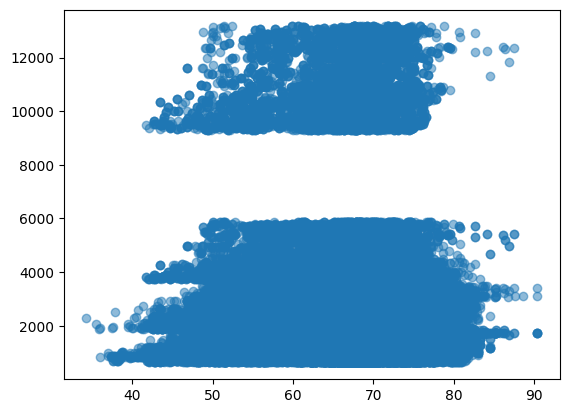

In [49]:
plt.scatter(x, y, alpha=0.5)

In [50]:
x2 = train_ft['습도(%)'].values

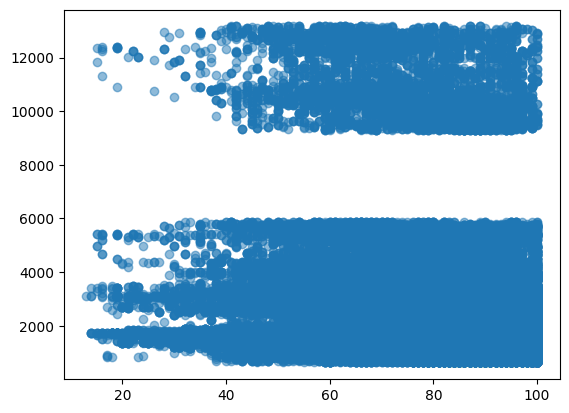

In [51]:
plt.scatter(x2, y, alpha=0.5)

In [53]:
y2 = train_ft['day_hour_median'].values

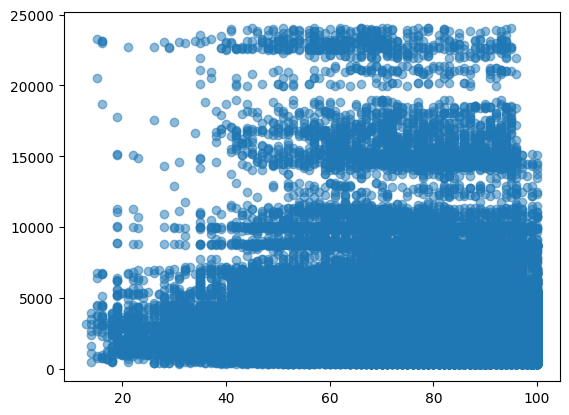

In [55]:
plt.scatter(x2, y2, alpha=0.5)

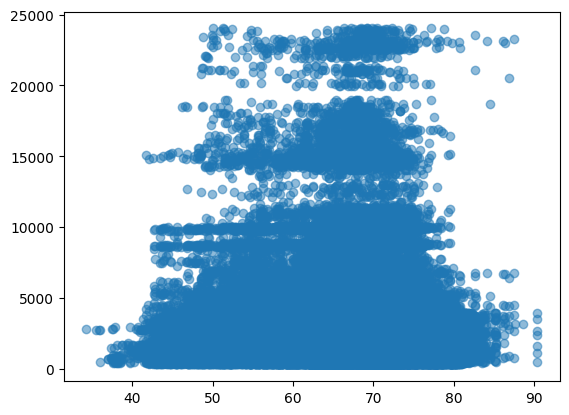

In [56]:
plt.scatter(x, y2, alpha=0.5)

In [57]:
x3 = train_ft['기온(C)'].values

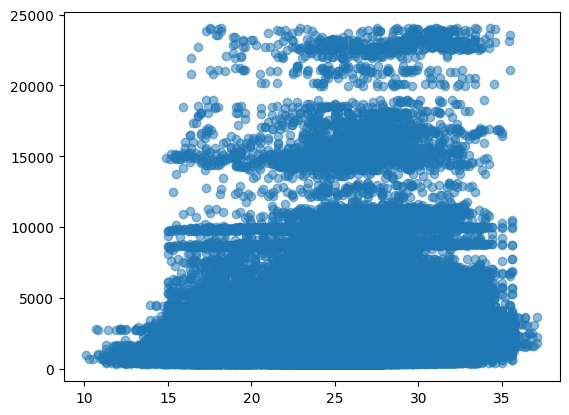

In [58]:
plt.scatter(x3, y2, alpha=0.5)

In [59]:
y3 = train_ft['전력소비량(kWh)'].values

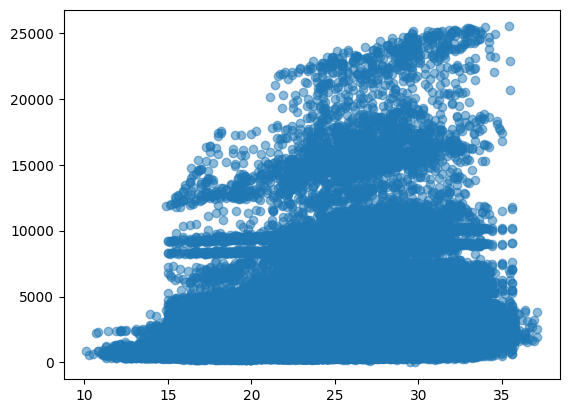

In [60]:
plt.scatter(x3, y3, alpha=0.5)

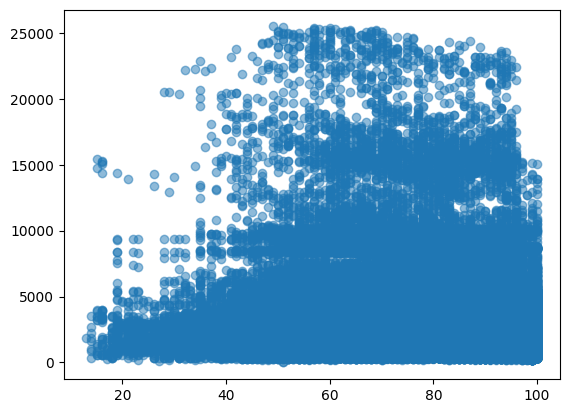

In [61]:
plt.scatter(x2, y3, alpha=0.5)

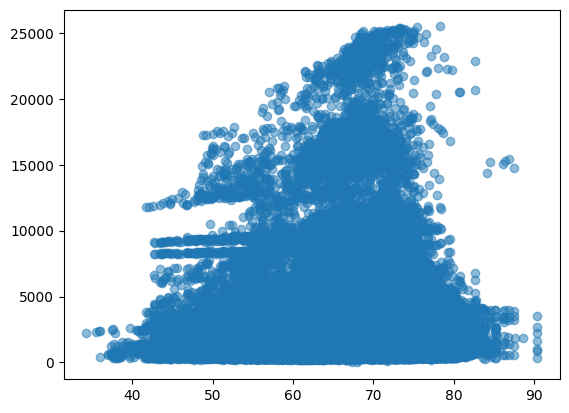

In [62]:
plt.scatter(x, y3, alpha=0.5)

비?

In [64]:
x3_2 = train_ft['기온_4일_이동평균'].values

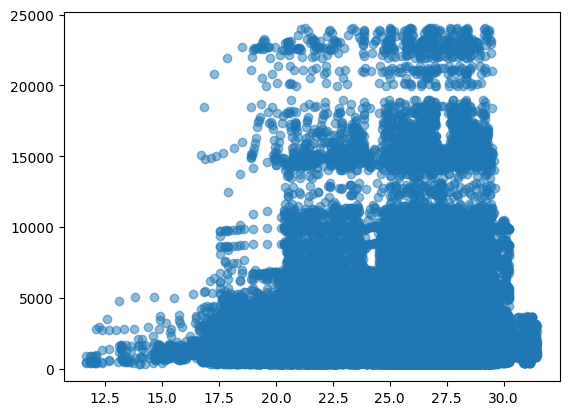

In [65]:
plt.scatter(x3_2, y2, alpha=0.5)

In [63]:
from sklearn.linear_model import LinearRegression

In [66]:
lr = LinearRegression()

In [67]:
Y = train_ft['day_hour_median'].values
Y

array([2094.72, 2015.52, 1848.  , ...,  781.2 ,  657.12,  553.2 ])

In [68]:
X = train_ft['THI'].values

In [69]:
X

array([49.6576, 47.7625, 47.2225, ..., 64.1976, 65.0744, 65.2725])

In [70]:
X = X.reshape(-1, 1)

In [71]:
Y = Y.reshape(-1,1)

In [72]:
X
Y

array([[2094.72],
       [2015.52],
       [1848.  ],
       ...,
       [ 781.2 ],
       [ 657.12],
       [ 553.2 ]])

In [73]:
lr.fit(X, Y)

LinearRegression()

In [74]:
print (lr.coef_[0])

[-2.14981395]


In [75]:
print (lr.intercept_)

[2640.62753801]


In [79]:
Y2 = lr.coef_[0]*X+lr.intercept_

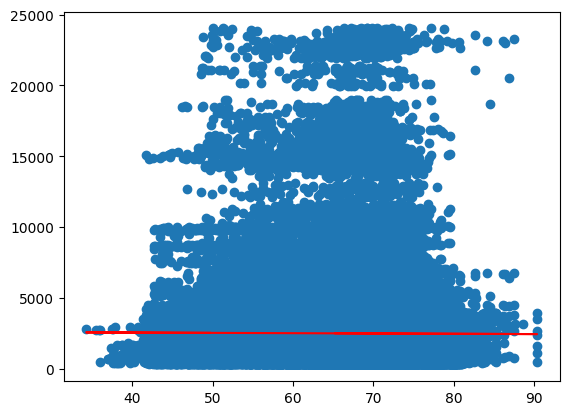

In [80]:
plt.scatter(X, Y)
plt.plot(X, Y2, color ='red')
plt.show()